# AI Insights: Geo-politics news reporter

Demonstrates the implementation of an intelligent news aggregation and summarization system using a multi-agent architecture. It automatically collects, processes, and summarizes geo-politics news for general audiences.

**Proposed approach**

1. **News searcher agent**
    - Primary news collection engine
    - Interfaces with Tavily API
    - Filters for relevance and recency
    - Handles source diversity

2. **Summarizer agent**
    - Processes technical content
    - Uses an LLM for natural language generation
    - Handles technical term simplification

3. **Publisher agent**
    - Takes list of summaries as input
    - Formats them into a structured prompt
    - Makes single LLM call to generate complete report with:
        * Introduction section
        * Organized summaries
        * Further reading links
    - Saves final report as markdown file

**Conclusion**

This notebook streamlines the process of staying informed about rapidly evolving fields by automating news collection, providing easily digestible summaries, and ensuring consistent, well-structured reporting. By reducing information overload, making technical content more accessible, and offering a scalable, maintainable architecture, saves time and effort, empowering users to remain current and knowledgeable in complex, and fast-moving field.

In [1]:
import os
import re
import torch
import pandas as pd
from datetime import datetime
from pydantic import BaseModel
from dotenv import load_dotenv
from tavily import TavilyClient
from langgraph.graph import StateGraph
from typing_extensions import TypedDict # python <3.12
from langchain_community.llms import VLLM
from IPython.display import display, Image
from langgraph.graph import StateGraph, END
from IPython.display import Markdown, display
from langchain_core.prompts import ChatPromptTemplate
from typing import Dict, List, Any, Optional
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

In [2]:
load_dotenv()
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

## Set up

### Get the model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
llm = VLLM(
    model="Qwen/Qwen2.5-3B-Instruct",
    trust_remote_code=True,  
    max_new_tokens=1200,
    top_k=10,
    top_p=0.90,
    temperature=0.1,
    #vllm_kwargs={"quantization": "awq"},
    device=device
)

INFO 12-15 16:29:47 config.py:350] This model supports multiple tasks: {'embedding', 'generate'}. Defaulting to 'generate'.
INFO 12-15 16:29:47 llm_engine.py:249] Initializing an LLM engine (v0.6.4.post1) with config: model='Qwen/Qwen2.5-3B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2.5-3B-Instruct, num_

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 12-15 16:29:51 model_runner.py:1077] Loading model weights took 5.7915 GB
INFO 12-15 16:29:54 worker.py:232] Memory profiling results: total_gpu_memory=15.99GiB initial_memory_usage=7.21GiB peak_torch_memory=8.32GiB memory_usage_post_profile=7.23GiB non_torch_memory=1.43GiB kv_cache_size=4.65GiB gpu_memory_utilization=0.90
INFO 12-15 16:29:54 gpu_executor.py:113] # GPU blocks: 8461, # CPU blocks: 7281
INFO 12-15 16:29:54 gpu_executor.py:117] Maximum concurrency for 32768 tokens per request: 4.13x
INFO 12-15 16:29:54 model_runner.py:1400] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-15 16:29:54 model_runner.py:1404] If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 12

### Data model and state management

In [5]:
class Article(BaseModel):
    """
    Represents a single news article
    Attributes:
        title (str): Article headline
        url (str): Source URL
        content (str): Article content
    """
    title: str
    url: str
    content: str

In [6]:
class Summary(TypedDict):
    """
    Represents a processed article summary
    
    Attributes:
        title (str): Original article title
        summary (str): Generated summary
        url (str): Source URL for reference
    """
    title: str
    summary: str
    url: str

In [7]:
class GraphState(TypedDict):
    """
    Maintains workflow state between agents
    
    Attributes:
        articles (Optional[List[Article]]): Found articles
        summaries (Optional[List[Summary]]): Generated summaries
        report (Optional[str]): Final compiled report
    """
    articles: Optional[List[Article]] 
    summaries: Optional[List[Summary]] 
    report: Optional[str] 

### Agent implementation

#### Search agent

In [8]:
class NewsSearcher:
    """
    Agent responsible for finding relevant AI/ML news articles
    using the Tavily search API
    """
    
    def search(self) -> List[Article]:
        """
        Performs news search with configured parameters
        
        Returns:
            List[Article]: Collection of found articles
        """
        response = tavily.search(
            query="recent developments in international conflicts and warzones", 
            topic="news",
            time_period="1w",
            search_depth="advanced",
            max_results=15
        )
        
        articles = []
        for result in response['results']:
            articles.append(Article(
                title=result['title'],
                url=result['url'],
                content=result['content']
            ))
        
        return articles

#### Summarizer agent

In [9]:
class Summarizer:
    """
    Agent that processes articles and generates accessible summaries
    using an LLM.
    """

    def __init__(self):
        schemas = [
            ResponseSchema(
                name="summary",
                description=(
                    "A summary of the given article in 2-3 sentences, "
                    "focusing on the key points."
                )
            ),
        ]

        self.parser = StructuredOutputParser.from_response_schemas(schemas)
        self.format_instructions = self.parser.get_format_instructions()

    def summarize(self, article: Article) -> str:
        """
        Generates an accessible summary of a single article.
        
        Args:
            article (Article): Article to summarize.
            
        Returns:
            str: Generated summary.
        """
        prompt = ChatPromptTemplate.from_template(
            (
                "You are an AI expert who makes complex topics accessible to general audiences. "
                "Summarize this article in 2-3 sentences, focusing on the key points and explaining "
                "any technical terms simply.\n"
                "News article title: {title}\n"
                "News article content: {content}\n"
                "In the 'summary' key, include the summary for the news article provided.\n"
                "Return the answer in JSON format.\n\n"
            )
        ).partial(format_instructions=self.format_instructions)

        chain = prompt | llm
        response = chain.invoke({"title": article.title, "content": article.content})
        response = self.parser.parse(response)
        response = response['summary']
        return response

#### Publisher agent

In [10]:
class Publisher:
    """
    Agent that compiles summaries into a formatted report 
    and saves it to disk
    """    

    def create_report(self, summaries: List[Dict]) -> str:
        """
        Creates and saves a formatted markdown report    
        Args:
            summaries (List[Dict]): Collection of article summaries
        Returns:
            str: Generated report content
        """
        
        # Format summaries for the LLM
        summaries_text = "\n\n".join([
            f"""
            News article title: {article['title']}
            News article content: {article['summary']}
            News article source: {article['url']}
            """ for article in summaries
        ])
        
        schemas = [
            ResponseSchema(
                name="overall_introduction",
                description=(
                    "Write a brief introduction about the latest developments in geopolitics. This section should provide "
                    "a global perspective on key developments and trends."
                )
            ),
            ResponseSchema(
                name="key_themes",
                description=(
                    "Select strictly no more than 5 of the most relevant news themes or developments and present them in a structured format "
                    "using bullet points. Each should include a title embedded as [title](url), followed by a summary."
                )
            ),
            ResponseSchema(
                name="other_reads",
                description=(
                    "List strictly no more than 3 other news items as bullet points with their titles embedded as [title](url) only. Do not include summaries."
                )
            )
        ]

        # Create output parser
        parser = StructuredOutputParser.from_response_schemas(schemas)
        format_instructions = parser.get_format_instructions()
        prompt = ChatPromptTemplate.from_template(
            """
            You are tasked with generating a markdown-formatted report titled 'Geopolitics Latest Developments'.
            Format the report as follows:
            
            # Geopolitics Latest Developments
            
            ## Overall Introduction
            Based on the information given at the end, write brief introduction of 2-3 sentences about the latest developments. 

            ## Key Themes/Developments
            - Title embedded as [title](url).
            - A brief summary of the article below the title.

            ## Other Reads
            - A list of article titles only, embedded as [title](url).

            {information}
            """
        ).partial(format_instructions=format_instructions)
        
        chain = prompt | llm
        response = chain.invoke({"information": summaries_text})
        response = response.split('Assistant:')[-1].replace('```','')
        response = response.strip().replace("\n-", "\n\n-")
        
        return response

### Workflow

#### Nodes

In [11]:
def search_node(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Node for article search.
    
    Args:
        state (Dict[str, Any]): Current workflow state.
        
    Returns:
        Dict[str, Any]: Updated state with found articles.
    """
    searcher = NewsSearcher()
    state['articles'] = searcher.search()
    return state

In [12]:
def summarize_node(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Node for article summarization.
    
    Args:
        state (Dict[str, Any]): Current workflow state.
        
    Returns:
        Dict[str, Any]: Updated state with summaries.
    """
    summarizer = Summarizer()
    state['summaries'] = []

    for article in state['articles']:  # Uses articles from the previous node
        summary = summarizer.summarize(article)
        state['summaries'].append({
            'title': article.title,
            'summary': summary,
            'url': article.url
        })
    
    return state

In [13]:
def publish_node(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    Node for report generation.
    
    Args:
        state (Dict[str, Any]): Current workflow state.
        
    Returns:
        Dict[str, Any]: Updated state with final report.
    """
    publisher = Publisher()
    report_content = publisher.create_report(state['summaries'])
    state['report'] = report_content
    
    return state

#### Graph creation

In [14]:
def create_workflow() -> StateGraph:
    """
    Constructs and configures the workflow graph.
    Workflow steps: search -> summarize -> publish.
    
    Returns:
        StateGraph: Compiled workflow ready for execution.
    """
    # Create a workflow (graph) initialized with our state schema
    workflow = StateGraph(state_schema=GraphState)
    
    # Add processing nodes that we will flow between
    workflow.add_node("search", search_node)
    workflow.add_node("summarize", summarize_node)
    workflow.add_node("publish", publish_node)
    
    # Define the flow with edges
    workflow.add_edge("search", "summarize")  # Search results flow to summarizer
    workflow.add_edge("summarize", "publish")  # Summaries flow to publisher
    
    # Set where to start
    workflow.set_entry_point("search")
    
    return workflow.compile()

## Use case

In [15]:
workflow = create_workflow()

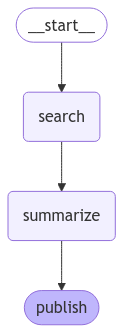

In [17]:
display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [18]:
final_state = workflow.invoke({
    "articles": None,
    "summaries": None,
    "report": None
})

Processed prompts: 100%|██████████| 1/1 [00:24<00:00, 24.07s/it, est. speed input: 109.07 toks/s, output: 49.86 toks/s]


In [19]:
display(Markdown(final_state['report']))

# Geopolitics Latest Developments

## Overall Introduction
The latest geopolitical developments in Syria and the broader Middle East have been marked by significant shifts, including the ousting of President Bashar al-Assad, ongoing conflicts, and international reactions. These changes have profound implications for regional stability and security.

## Key Themes/Developments

- [Syria’s Future on Unannounced Visit to Iraq](https://www.nytimes.com/video/world/middleeast/100000009876711/blinken-syria-iraq.html)
  - U.S. Secretary of State Antony Blinken discussed Syria's future during an unannounced visit to Iraq, touching on various ongoing conflicts and developments in the region.


- [Defense Minister Katz on Syria’s Threat](https://www.timesofisrael.com/katz-despite-rebel-assurances-syria-threat-requires-boost-to-defense-budget/)
  - Defense Minister Israel Katz emphasized the need to boost the defense budget in response to growing threats in Syria, particularly the ousting of President Assad.


- [Syria Faces Crisis and Gaza Heads Toward Famine](https://www.bozemandailychronicle.com/ap_news/international/syria-faces-crisis-and-gaza-heads-toward-famine-world-food-program-official-says/article_080e08b1-df16-51e9-a5bc-fdec2748d23c.html)
  - The World Food Program's deputy executive director visited Syria and Gaza to assess severe humanitarian crises, highlighting the urgent need for international assistance.


- [War Destroys and Divides Aleppo](https://www.washingtonpost.com/world/2024/12/13/aleppo-syria-assad-hts-minorities-christians/)
  - The article discusses the impact of the Israel-Gaza war on Aleppo, speculating that the fall of President Assad could potentially unite the city, which has been deeply divided by various conflicts.


- [Searching for Syria’s Disappeared](https://www.nytimes.com/video/world/middleeast/100000009871973/syria-missing-disappeared-assad.html?playlistId=video/world)
  - The article focuses on the ongoing search for missing individuals in Syria, including a man who was freed from a prison and appears to be an American missing person.


- [Syria Latest: Diplomats Gather in Jordan for Summit](https://news.sky.com/story/syria-latest-rebel-fighters-ordered-to-withdraw-from-cities-as-leader-will-name-assad-officials-wanted-for-torture-13265154)
  - Diplomats from various nations gathered in Jordan to discuss Syria's transition, with Russia withdrawing its military from the front lines but maintaining its bases.

## Other Reads

- [Yermak Andrii Borysovych](https://ukranews.com/en/dossier/212-yermak-andrii-borysovych)
  - Highlights various developments in the ongoing conflict, including air defense successes, reported drone attacks, and ongoing chemical attacks by Russia.


- [Israel Will Close its Ireland Embassy Over Gaza Tensions](https://www.military.com/daily-news/2024/12/15/israel-will-close-its-ireland-embassy-over-gaza-tensions-palestinian-death-toll-nears-45000.html)
  - Israel announced it will close its embassy in Ireland in response to extreme anti-Israel policies in Gaza.


- [Syria Latest: US Has Been 'In Contact' with Rebel Group](https://news.sky.com/story/syria-latest-us-has-been-in-contact-with-rebel-group-israel-condemned-over-unjustified-syria-attacks-13265154)
  - Sky News reported that the United States has been in contact with a rebel group in Syria, while Israel faced condemnation for its 'unjustified' attacks on the country.


- [Tehran Anxiously Examines Assad’s Fall](https://www.ynetnews.com/article/hydazgh4ye)
  - Iran's cautious examination of the fall of Syrian leader Bashar Assad, fearing a similar fate for its own Islamic regime.


- [South Korean Leaders Seek Calm After Yoon is Impeached](https://www.military.com/daily-news/2024/12/15/south-korean-leaders-seek-calm-after-yoon-impeached.html)
  - South Korean leaders called for calm after the impeachment of President Yoon, amid heightened security measures and ongoing concerns about the U.S. Department of Veterans Affairs' health system.


- [Trump Talks Ukraine and Middle East Conflicts](https://en.tempo.co/read/1952358/trump-talks-ukraine-and-middle-east-conflicts-in-time-magazine-person-of-the-year-interview)
  - U.S. President-elect Donald Trump discussed his plans to resolve conflicts in the Middle East and expressed distrust towards international leaders, including Israel's Prime Minister Benjamin Netanyahu. 


- [US Navy Returns to Cambodia](https://www.newsweek.com/us-navy-returns-cambodia-after-8-years-amid-china-base-tensions-2000521)
  - The U.S. Navy is set to return to Cambodia for the first time in eight years, amid growing tensions over China's expanding military footprint in the region. 

These articles provide a comprehensive overview of the latest geopolitical developments, highlighting the complex and interconnected nature of the conflicts in Syria, the Middle East, and beyond.